### Data load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../../../Novartis/data/Boronic_reagents_mordred.csv")

C:\Users\AndrzejZuranski\Software\Miniconda3\envs\autoqchem\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# split info columns from descriptor columns
info = data[data.columns[0:7]]
df = data[data.columns[7:]]

print (df.shape)

(14489, 997)


In [6]:
# if you run a test and only want a sample of molecules studied uncomment
# the line below

# df=df.sample(1000)

,compound,inchi,aryl,type,NV,Reaxys,Common,ABC,ABCGG,nAcid,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,NV_1,InChI=1S/C9H12BClO3/c1-6(2)14-9-4-3-7(11)5-8(9...,aryl,ba,True,True,True,10.365564,9.738246,0,...,0.000000,9.299175,45.122750,214.056802,8.232954,300,18,66.0,73.0,3.138889
1,NV_2,InChI=1S/C8H10BFO2/c1-5-4-8(10)6(2)3-7(5)9(11)...,aryl,ba,True,True,True,8.910910,8.583028,0,...,0.000000,9.296977,42.737439,168.075788,7.639809,187,17,58.0,66.0,2.666667
2,NV_3,"InChI=1S/C12H16BFO2/c1-11(2)12(3,4)16-13(15-11...",aryl,bpin,True,True,True,12.630705,11.241455,0,...,7.195187,9.919115,63.748556,222.122738,6.941336,423,25,88.0,104.0,3.256944
3,NV_4,"InChI=1S/C15H24BNO4/c1-13(2,3)19-12(18)17-10-8...",hetaryl,bpin,True,True,True,16.562115,15.535186,0,...,7.635787,10.172560,71.682278,293.179839,6.515108,899,32,116.0,136.0,4.187500
4,NV_5,InChI=1S/C12H11BO3/c14-13(15)10-6-8-12(9-7-10)...,aryl,ba,True,True,True,12.199155,9.978922,0,...,0.000000,9.370331,47.806046,214.080125,7.928894,489,20,78.0,87.0,3.611111


### Preprocessing

In [7]:
from sklearn.preprocessing import scale
from scipy.linalg import qr # qr decomposition

In [8]:
# standardize
df=pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [9]:
# preprocessing

# zero-variance columns
zero_std_cols = df.columns[df.std() == 0]
df=df[df.columns.difference(zero_std_cols)]

print (df.shape)

(14489, 869)


In [10]:
# preprocessing continued

# drop linearly dependent columns (use qr decomposition in a rank revealing way)
tol=1e-8 # numeric tolerance for 0
Q, R, P = qr(df, pivoting=True) # pivoting qr decomposition (may take long), sorted diagonal values in R
rank=sum(np.abs(np.diag(R)) > tol) # calculate the rank of the matrix using the R part
col_idx_to_keep = P[:rank] # fetch the top features from the P pivot vector
df=df[df.columns[col_idx_to_keep]]

print (df.shape)

(14489, 762)


In [11]:
# preprocessing continued

# drop highly correlated columns
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)

print (df.shape)

(14489, 440)


### Dimensionality reduction

In [12]:
from sklearn.decomposition import PCA
from umap import UMAP

In [13]:
# first create embeddings for visualization, these have 2 dimensions only

dfs={}
dfs['all'] = df

# First 2 principal components
dfs['pc2'] = pd.DataFrame(PCA(n_components=2).fit_transform(df),
                      index=df.index,
                      columns=["PC1", "PC2"])

# 2-dim umap embedding
nneigh = np.int(np.sqrt(df.shape[1]))
dfs['umap2'] = pd.DataFrame(UMAP(n_components=2,
                             n_neighbors=nneigh).fit_transform(df),
                        index=df.index,
                        columns=["UMAP1", "UMAP2"])

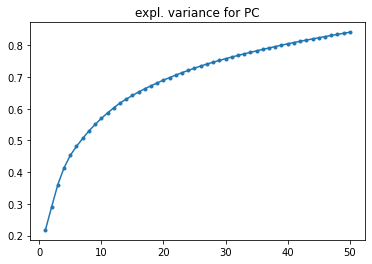

In [18]:
# explained variance plot

pc=PCA()
pc.fit(df)
expl_var=pc.explained_variance_ratio_.cumsum()
pd.Series(expl_var, index=range(1, df.shape[1]+1)).loc[:50].plot(style=".-",
                                                                title="expl. variance for PC")

Text(0.5, 1.0, 'UMAP projection')

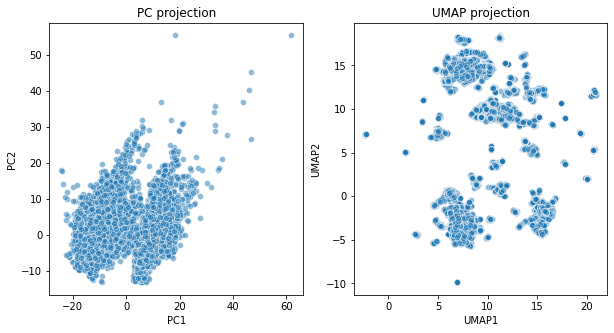

In [19]:
# Let's visualize the visualization embeddings

f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot('PC1', 'PC2', data=dfs['pc2'], alpha=0.5, ax=ax[0]).set_title("PC projection")
sns.scatterplot('UMAP1', 'UMAP2', data=dfs['umap2'], alpha=0.5, ax=ax[1]).set_title("UMAP projection")

In [22]:
# create dimensionality reductions for clusterings

# First 10 principal components (should cover quite a bit of variance, no
# matter what dataset you have)
dfs['pc10'] = pd.DataFrame(PCA(n_components=10).fit_transform(df),
                      index=df.index,
                      columns=[f"PC{i}" for i in range(1, 11)])

# 10-dim umap embedding
dfs['umap10'] = pd.DataFrame(UMAP(n_components=10,
                              n_neighbors=nneigh).fit_transform(df),
                        index=df.index,
                        columns=[f"UMAP{i}" for i in range(1, 11)])

### Clustering

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.spatial.distance import pdist, cdist, squareform

In [66]:
# Let's compare 3 parametrizations: All features, pc10, and umap10

NCLS = 20 # fix the number of clusters for further cells (change this as desired)

Z={}
# compute linkages - this is the Agglomerative Hierarchical Clustering
Z['all'] = linkage(dfs['all'], method="ward")
Z['pc10'] = linkage(dfs['pc10'], method="ward")
Z['umap10'] = linkage(dfs['umap10'], method="ward")

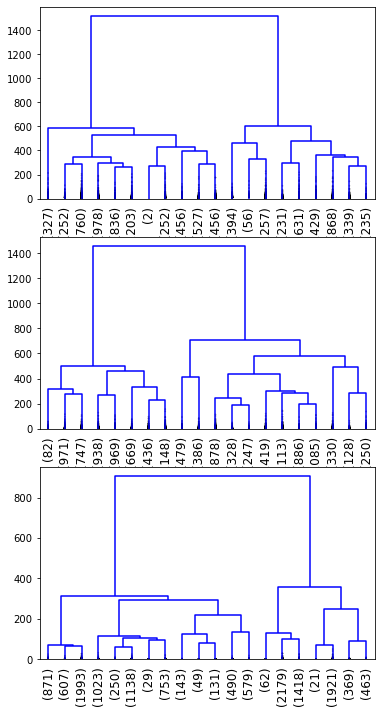

In [67]:
# plot some dendrograms (python doesn't have great plotting for dendrograms..)
f, ax = plt.subplots(3, 1, figsize=(6,12))
_=dendrogram(Z['all'], truncate_mode='lastp', p=NCLS, show_contracted=True,
          leaf_rotation=90, ax=ax[0], color_threshold=0)
_=dendrogram(Z['pc10'], truncate_mode='lastp', p=NCLS, show_contracted=True,
          leaf_rotation=90, ax=ax[1], color_threshold=0)
_=dendrogram(Z['umap10'], truncate_mode='lastp', p=NCLS, show_contracted=True,
          leaf_rotation=90, ax=ax[2], color_threshold=0)

In [68]:
# chop the dendrograms at a given height and get the cluster assignments
cls = {}
cls['all'] = fcluster(Z['all'], NCLS, criterion='maxclust')
cls['pc10'] = fcluster(Z['pc10'], NCLS, criterion='maxclust')
cls['umap10'] = fcluster(Z['umap10'], NCLS, criterion='maxclust')

Text(0.5, 1.0, '10 UMAPs - 2-UMAP projection')

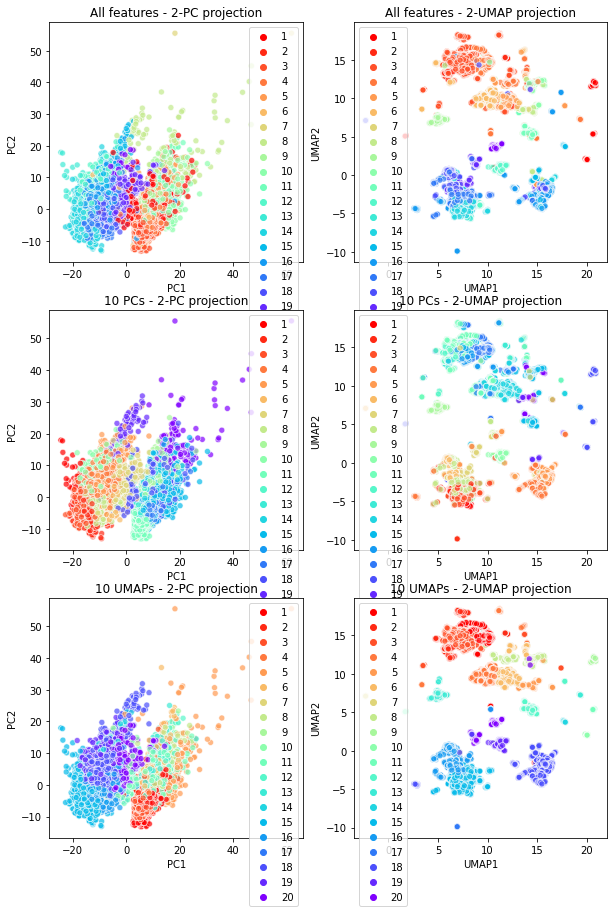

In [69]:
# clustering visualizations

f, ax = plt.subplots(3, 2, figsize=(10, 15))
color_threshold=0
sns.scatterplot("PC1", "PC2", data=dfs['pc2'], ax=ax[0][0], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['all']).set_title("All features - 2-PC projection")
sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], ax=ax[0][1], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['all']).set_title("All features - 2-UMAP projection")
sns.scatterplot("PC1", "PC2", data=dfs['pc2'], ax=ax[1][0], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['pc10']).set_title("10 PCs - 2-PC projection")
sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], ax=ax[1][1], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['pc10']).set_title("10 PCs - 2-UMAP projection")
sns.scatterplot("PC1", "PC2", data=dfs['pc2'], ax=ax[2][0], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['umap10']).set_title("10 UMAPs - 2-PC projection")
sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], ax=ax[2][1], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['umap10']).set_title("10 UMAPs - 2-UMAP projection")

In [70]:
from sklearn.metrics import silhouette_score

In [59]:
KMeans(n_clusters=3).fit(dfs['umap10']).labels_

array([2, 2, 1, ..., 2, 2, 0])

In [62]:
from sklearn.cluster import KMeans

for n in range(10, 20):
    cls = KMeans(n_clusters=n).fit(dfs['umap10']).labels_
    print (n, silhouette_score(dfs['umap10'], cls))

10 0.5622743
11 0.5712191
12 0.510485
13 0.50268835
14 0.53858024
15 0.4992988
16 0.4891058
17 0.5117481
18 0.45607838
19 0.47210616


In [41]:
#help(silhouette_score)
print (silhouette_score(dfs['all'], cls['all']))
print (silhouette_score(dfs['pc10'], cls['pc10']))
print (silhouette_score(dfs['umap10'], cls['umap10']))

0.09883378582638269
0.13105408105621075
0.62126243


In [71]:
# compute consistency scores between the 3 clusterings
cls_df=pd.DataFrame(cls)

dists=pd.DataFrame(squareform(pdist(cls_df.T, metric=adjusted_rand_score)),
             columns=cls_df.columns, index=cls_df.columns)
dists.round(2)

,all,pc10,umap10
all,0.00,0.39,0.55
pc10,0.39,0.00,0.37
umap10,0.55,0.37,0.00


### Get central molecules each cluster

In [72]:
from rdkit import Chem
from rdkit.Chem import Draw

In [73]:
# produce rdkit molecules
mols=pd.Series(info.inchi.map(Chem.MolFromInchi), index=info.index).to_frame('mol')

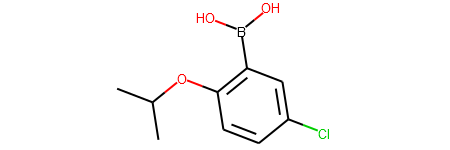

In [74]:
mols.mol[0]

In [75]:
# concat molecules and clusters
mols=pd.concat([cls_df, mols], axis=1).dropna()

In [76]:
mols[mols['all'] != 1]

,all,pc10,umap10,mol
0,17,8,16,<rdkit.Chem.rdchem.Mol object at 0x0000021449C...
1,17,2,15,<rdkit.Chem.rdchem.Mol object at 0x0000021454E...
2,3,11,3,<rdkit.Chem.rdchem.Mol object at 0x00000214498...
3,3,15,1,<rdkit.Chem.rdchem.Mol object at 0x00000214498...
4,16,5,18,<rdkit.Chem.rdchem.Mol object at 0x00000214498...
...,...,...,...,...
14484,14,3,15,<rdkit.Chem.rdchem.Mol object at 0x00000214527...
14485,19,7,20,<rdkit.Chem.rdchem.Mol object at 0x00000214527...
14486,14,3,15,<rdkit.Chem.rdchem.Mol object at 0x00000214527...
14487,17,8,16,<rdkit.Chem.rdchem.Mol object at 0x00000214527...


Cluster 1, n molecules: 327


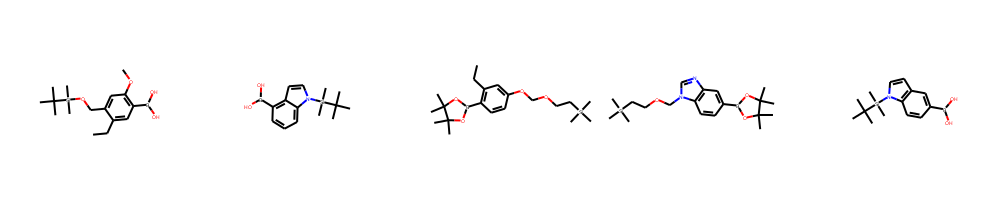

Cluster 2, n molecules: 252


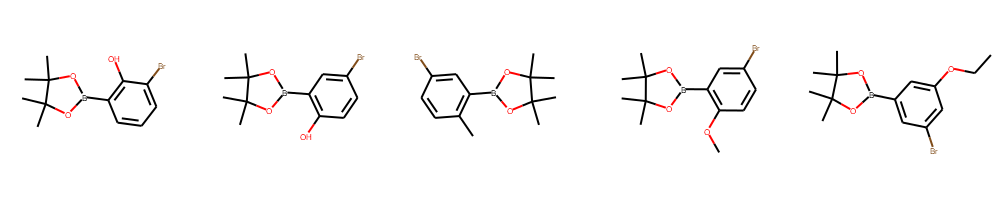

Cluster 3, n molecules: 2760


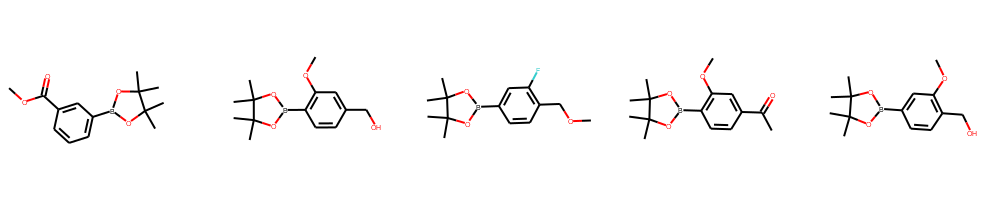

Cluster 4, n molecules: 978


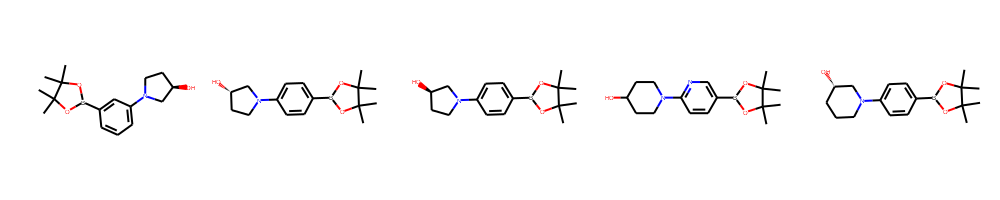

Cluster 5, n molecules: 836


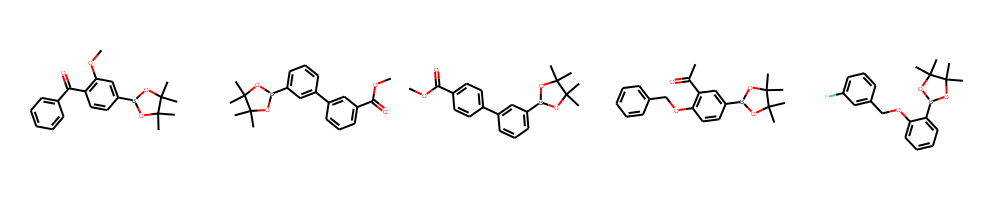

Cluster 6, n molecules: 1203


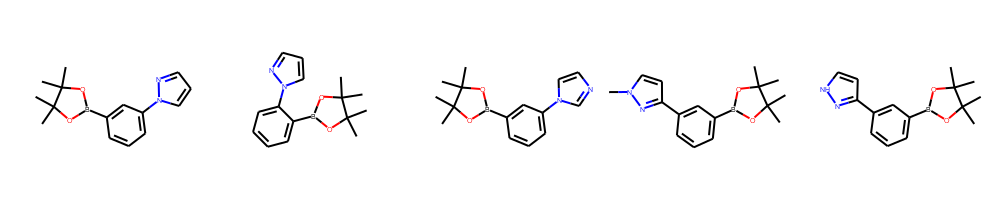

Cluster 7, n molecules: 2


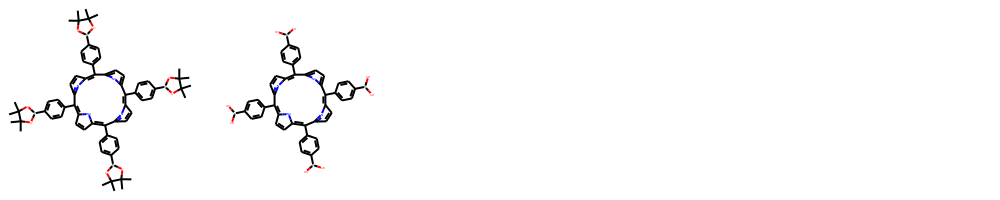

Cluster 8, n molecules: 252


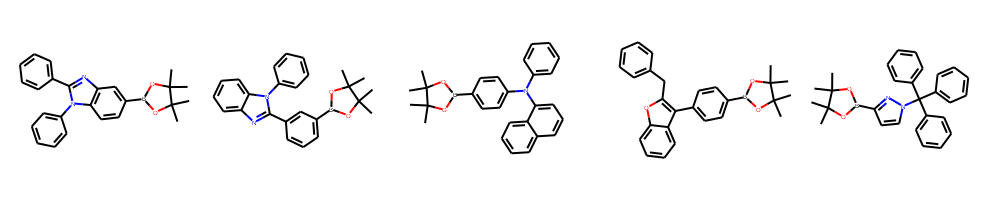

Cluster 9, n molecules: 456


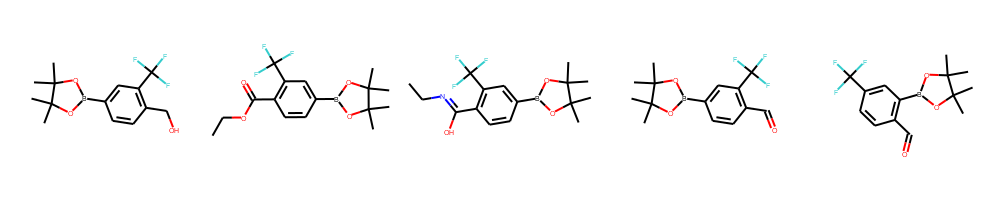

Cluster 10, n molecules: 527


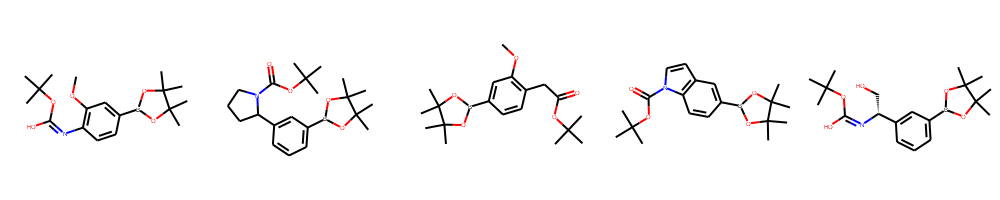

Cluster 11, n molecules: 456


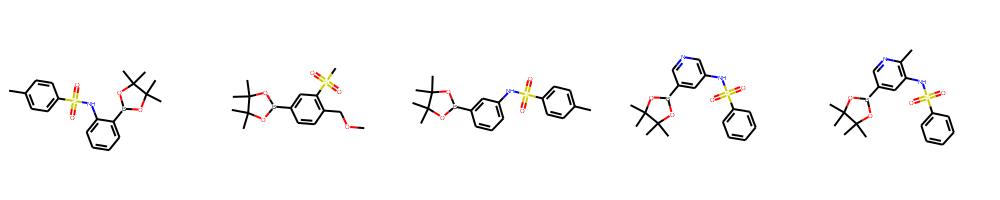

Cluster 12, n molecules: 394


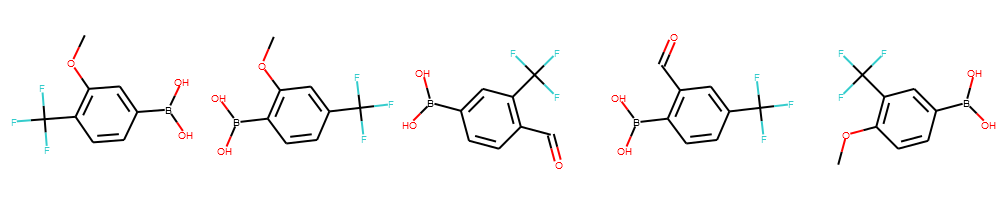

Cluster 13, n molecules: 56


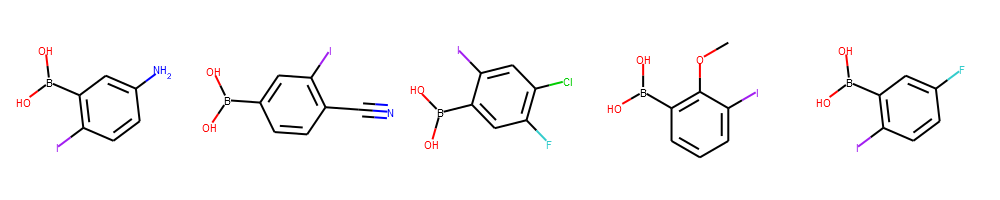

Cluster 14, n molecules: 1257


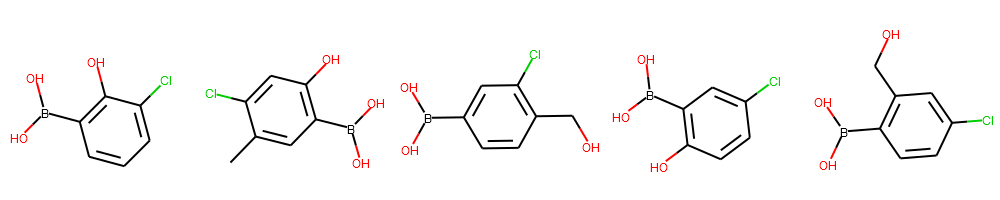

Cluster 15, n molecules: 231


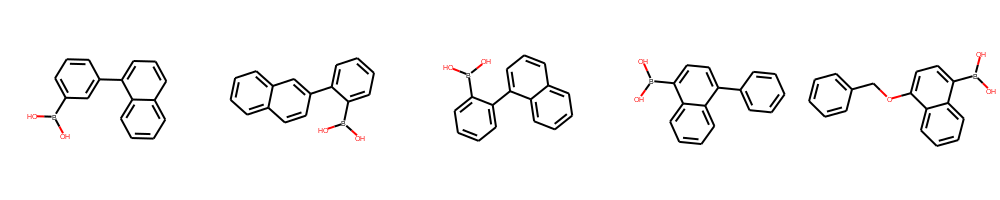

Cluster 16, n molecules: 1631


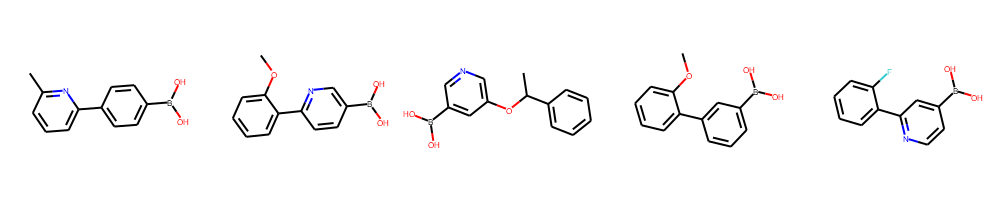

Cluster 17, n molecules: 1429


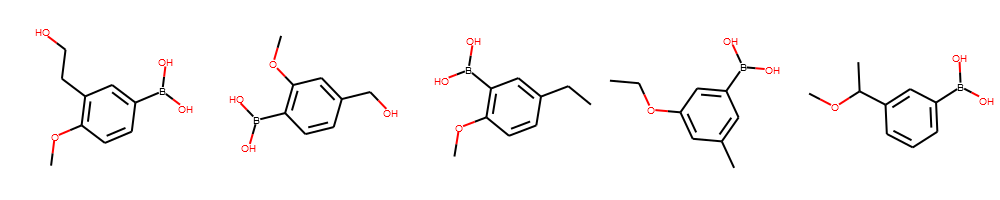

Cluster 18, n molecules: 868


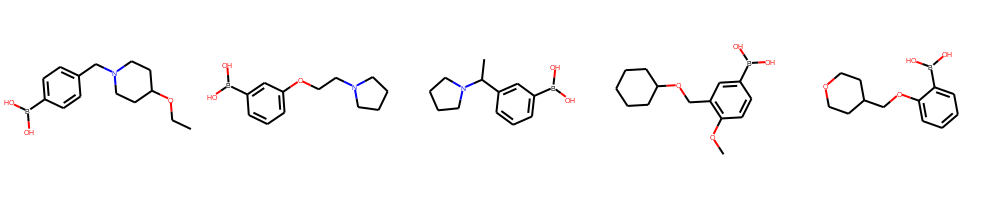

Cluster 19, n molecules: 339


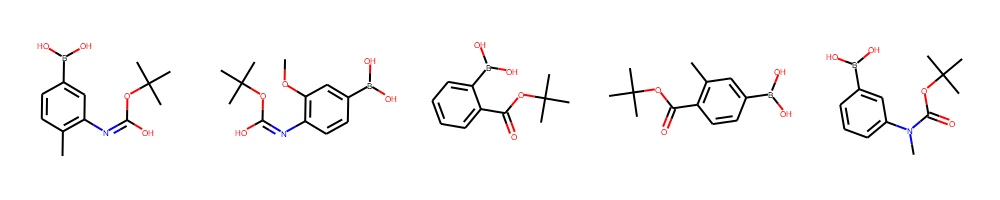

Cluster 20, n molecules: 235


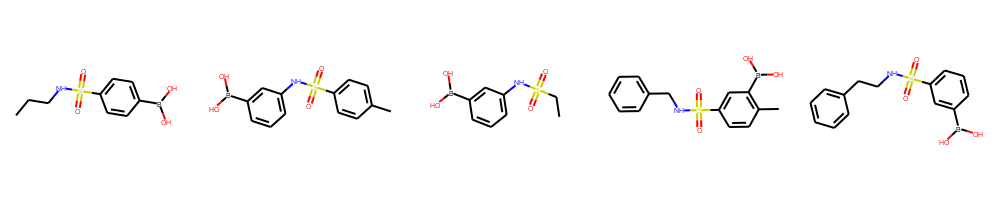

In [77]:
clustering = 'all' # change this to see what other clusterings are doing

# Loop over clusters and pick n central
n_per_cluster = 5

centers = dfs[clustering].groupby(cls_df[clustering]).mean()


for group, data in mols.groupby(clustering):
    # get descriptor data for this clsutering
    desc_data=dfs[clustering].loc[data.index]
    
    # compute distances of these molecules to their center
    dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
                    index=desc_data.index)
    # select top n central molecules
    selected=dists.sort_values().head(n_per_cluster).index
    
    print (f"Cluster {group}, n molecules: {len(data)}")
    ms = data['mol'].loc[selected]
    display(Draw.MolsToGridImage(ms, molsPerRow=5))